# N-gram Language Modeling

In [1]:
from collections import defaultdict
import math
import os

print(os.getcwd())  # 顯示目前的工作目錄

# 讀取數據
def load_data(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        data = file.readlines()
    return [line.strip().split() for line in data]

# 構建 <UNK> 標記，包含少於等於三次的詞
def process_unk_tokens(data, min_count=3):
    word_counts = defaultdict(int)
    for sentence in data:
        for word in sentence:
            word_counts[word] += 1

    processed_data = []
    for sentence in data:
        processed_sentence = [word if word_counts[word] >= min_count else "<UNK>" for word in sentence]
        processed_data.append(processed_sentence)
    return processed_data

# 構建 unigram 模型
def build_unigram_model(data):
    word_counts = defaultdict(int)
    total_count = 0
    for sentence in data:
        for word in sentence + ["<STOP>"]:  # 添加 <STOP> 到每句結尾
            word_counts[word] += 1
            total_count += 1
    # 計算機率
    unigram_prob = {word: count / total_count for word, count in word_counts.items()}
    return unigram_prob

# 計算困惑度
def calculate_perplexity(model, data):
    perplexity = 0
    total_words = 0
    for sentence in data:
        sentence = sentence + ["<STOP>"]  # 確保只包含 <STOP>，排除 <START>
        for word in sentence:
            prob = model.get(word, model.get("<UNK>", 1e-6))  # 使用 <UNK> 來處理未見詞
            perplexity += -math.log2(prob)
            total_words += 1
    return 2 ** (perplexity / total_words)

# 構建 bigram 模型
def build_bigram_model(data):
    bigram_counts = defaultdict(lambda: defaultdict(int))
    unigram_counts = defaultdict(int)
    for sentence in data:
        sentence = ["<START>"] + sentence + ["<STOP>"]
        for i in range(1, len(sentence)):
            unigram_counts[sentence[i - 1]] += 1
            bigram_counts[sentence[i - 1]][sentence[i]] += 1
        unigram_counts[sentence[-1]] += 1  # 更新最後詞的 unigram 計數
    # 計算條件機率
    bigram_prob = {w1: {w2: count / unigram_counts[w1] for w2, count in w2_dict.items()} 
                   for w1, w2_dict in bigram_counts.items()}
    return bigram_prob

def calculate_bigram_perplexity(model, data):
    perplexity = 0
    total_words = 0
    for sentence in data:
        sentence = ["<START>"] + sentence + ["<STOP>"]
        for i in range(1, len(sentence)):
            prob = model.get(sentence[i - 1], {}).get(sentence[i], 1e-6)
            perplexity += -math.log2(prob)
            total_words += 1
    return 2 ** (perplexity / total_words)

# 構建 trigram 模型
def build_trigram_model(data):
    trigram_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
    bigram_counts = defaultdict(lambda: defaultdict(int))
    for sentence in data:
        sentence = ["<START>"] + sentence + ["<STOP>"]
        for i in range(2, len(sentence)):
            bigram_counts[sentence[i - 2]][sentence[i - 1]] += 1
            trigram_counts[sentence[i - 2]][sentence[i - 1]][sentence[i]] += 1
    # 計算條件機率
    trigram_prob = {w1: {w2: {w3: count / bigram_counts[w1][w2] for w3, count in w3_dict.items()} 
                         for w2, w3_dict in w2_dict.items()} 
                    for w1, w2_dict in trigram_counts.items()}
    return trigram_prob

def calculate_trigram_perplexity(model, data, bigram_model):
    perplexity = 0
    total_words = 0
    for sentence in data:
        sentence = ["<START>", "<START>"] + sentence + ["<STOP>"]
        for i in range(2, len(sentence)):
            # 對於第一個詞，使用 bigram 機率
            if i == 2:
                prob = bigram_model.get(sentence[i - 1], {}).get(sentence[i], 1e-6)
            else:
                prob = model.get(sentence[i - 2], {}).get(sentence[i - 1], {}).get(sentence[i], 1e-6)
            perplexity += -math.log2(prob)
            total_words += 1
    return 2 ** (perplexity / total_words)

# 測試函數
train_data = load_data('HW2/A2-Data/1b_benchmark.train.tokens')
dev_data = load_data('HW2/A2-Data/1b_benchmark.dev.tokens')
test_data = load_data('HW2/A2-Data/1b_benchmark.test.tokens') 

# 處理 <UNK> 標記
train_data = process_unk_tokens(train_data)
dev_data = process_unk_tokens(dev_data)

# 構建模型
unigram_model = build_unigram_model(train_data)
bigram_model = build_bigram_model(train_data)
trigram_model = build_trigram_model(train_data)

test_sentence = [["HDTV", "."]]
print("\nTesting with sentence: 'HDTV .'")
unigram_test_perplexity = calculate_perplexity(unigram_model, test_sentence)
bigram_test_perplexity = calculate_bigram_perplexity(bigram_model, test_sentence)
trigram_test_perplexity = calculate_trigram_perplexity(trigram_model, test_sentence, bigram_model)
print(f"Unigram Model - Test Perplexity (HDTV .): {unigram_test_perplexity}")
print(f"Bigram Model - Test Perplexity (HDTV .): {bigram_test_perplexity}")
print(f"Trigram Model - Test Perplexity (HDTV .): {trigram_test_perplexity}")
print("Final Ans=======================================\n")
# 計算並顯示訓練數據困惑度
train_perplexity = calculate_perplexity(unigram_model, train_data)
bigram_train_perplexity = calculate_bigram_perplexity(bigram_model, train_data)
trigram_train_perplexity = calculate_trigram_perplexity(trigram_model, train_data, bigram_model)

print(f"Unigram Model - Train Perplexity: {train_perplexity}")
print(f"Bigram Model - Train Perplexity: {bigram_train_perplexity}")
print(f"Trigram Model - Train Perplexity: {trigram_train_perplexity}")

# 計算並顯示開發數據困惑度
dev_perplexity = calculate_perplexity(unigram_model, dev_data)
bigram_dev_perplexity = calculate_bigram_perplexity(bigram_model, dev_data)
trigram_dev_perplexity = calculate_trigram_perplexity(trigram_model, dev_data, bigram_model)

print(f"Unigram Model - Development Perplexity: {dev_perplexity}")
print(f"Bigram Model - Development Perplexity: {bigram_dev_perplexity}")
print(f"Trigram Model - Development Perplexity: {trigram_dev_perplexity}")


C:\Users\USER\Downloads\NLP-Courses\NLP201\Assignments

Testing with sentence: 'HDTV .'
Unigram Model - Test Perplexity (HDTV .): 658.0445066285465
Bigram Model - Test Perplexity (HDTV .): 63.70757362051903
Trigram Model - Test Perplexity (HDTV .): 39.47865107091444
Final Ans=======================================

Unigram Model - Train Perplexity: 976.5437422251438
Bigram Model - Train Perplexity: 77.07346595596329
Trigram Model - Train Perplexity: 7.872967947037739
Unigram Model - Development Perplexity: 630.4870102149355
Bigram Model - Development Perplexity: 341.6427122419012
Trigram Model - Development Perplexity: 6846.7130978137475


# Smoothing with Linear Interpolation

In [2]:
import math
from collections import defaultdict

def calculate_interpolated_perplexity(unigram_model, bigram_model, trigram_model, data, lambda1, lambda2, lambda3):
    perplexity = 0
    total_words = 0
    for sentence in data:
        sentence = ["<START>", "<START>"] + sentence + ["<STOP>"]
        for i in range(2, len(sentence)):
            unigram_prob = unigram_model.get(sentence[i], unigram_model.get("<UNK>", 1e-6))
            bigram_prob = bigram_model.get(sentence[i - 1], {}).get(sentence[i], 1e-6)
            trigram_prob = trigram_model.get(sentence[i - 2], {}).get(sentence[i - 1], {}).get(sentence[i], 1e-6)
            
            # Interpolated probability with smoothing
            interpolated_prob = lambda1 * unigram_prob + lambda2 * bigram_prob + lambda3 * trigram_prob
            perplexity += -math.log2(interpolated_prob)
            total_words += 1
    return 2 ** (perplexity / total_words)

# Define five sets of lambda values
lambda_combinations = [
    (0.3, 0.3, 0.4),
    (0.1, 0.3, 0.6),
    (0.2, 0.4, 0.4),
    (0.5, 0.3, 0.2),
    (0.4, 0.4, 0.2)
]

# Variables to store the best results
best_dev_perplexity = float('inf')
best_lambda_combination = None

# Calculate perplexity for each set of lambda values
for lambda1, lambda2, lambda3 in lambda_combinations:
    train_perplexity = calculate_interpolated_perplexity(
        unigram_model, bigram_model, trigram_model, train_data, lambda1, lambda2, lambda3
    )
    dev_perplexity = calculate_interpolated_perplexity(
        unigram_model, bigram_model, trigram_model, dev_data, lambda1, lambda2, lambda3
    )
    
    print(f"Lambda values (λ1={lambda1}, λ2={lambda2}, λ3={lambda3}) - Train Perplexity: {train_perplexity}")
    print(f"Lambda values (λ1={lambda1}, λ2={lambda2}, λ3={lambda3}) - Development Perplexity: {dev_perplexity}")
    
    # Update best perplexity and lambda combination
    if dev_perplexity < best_dev_perplexity:
        best_dev_perplexity = dev_perplexity
        best_lambda_combination = (lambda1, lambda2, lambda3)

# Output the best lambda values and development perplexity
print(f"Best Lambda values: λ1={best_lambda_combination[0]}, λ2={best_lambda_combination[1]}, λ3={best_lambda_combination[2]}")
print(f"Best Development Perplexity: {best_dev_perplexity}")

# Calculate perplexity on the test set using the best lambda values
train_perplexity = calculate_interpolated_perplexity(
    unigram_model, bigram_model, trigram_model, train_data, *best_lambda_combination
)
test_perplexity = calculate_interpolated_perplexity(
    unigram_model, bigram_model, trigram_model, test_data, *best_lambda_combination
)

print(f"Train Perplexity with Best Lambda: {train_perplexity}")
print(f"Test Perplexity with Best Lambda: {test_perplexity}")


Lambda values (λ1=0.3, λ2=0.3, λ3=0.4) - Train Perplexity: 15.755112256072842
Lambda values (λ1=0.3, λ2=0.3, λ3=0.4) - Development Perplexity: 209.61352238735776
Lambda values (λ1=0.1, λ2=0.3, λ3=0.6) - Train Perplexity: 11.607682837465887
Lambda values (λ1=0.1, λ2=0.3, λ3=0.6) - Development Perplexity: 243.8120805151031
Lambda values (λ1=0.2, λ2=0.4, λ3=0.4) - Train Perplexity: 15.066547843281448
Lambda values (λ1=0.2, λ2=0.4, λ3=0.4) - Development Perplexity: 204.81727594138965
Lambda values (λ1=0.5, λ2=0.3, λ3=0.2) - Train Perplexity: 25.479144820341563
Lambda values (λ1=0.5, λ2=0.3, λ3=0.2) - Development Perplexity: 208.26178388270165
Lambda values (λ1=0.4, λ2=0.4, λ3=0.2) - Train Perplexity: 23.965263010966545
Lambda values (λ1=0.4, λ2=0.4, λ3=0.2) - Development Perplexity: 196.80795071526921
Best Lambda values: λ1=0.4, λ2=0.4, λ3=0.2
Best Development Perplexity: 196.80795071526921
Train Perplexity with Best Lambda: 23.965263010966545
Test Perplexity with Best Lambda: 302.32328696

In [3]:
import optuna
import math
from collections import defaultdict

def calculate_interpolated_perplexity(unigram_model, bigram_model, trigram_model, data, lambda1, lambda2, lambda3):
    perplexity = 0
    total_words = 0
    for sentence in data:
        sentence = ["<START>", "<START>"] + sentence + ["<STOP>"]
        for i in range(2, len(sentence)):
            unigram_prob = unigram_model.get(sentence[i], unigram_model.get("<UNK>", 1e-6))
            bigram_prob = bigram_model.get(sentence[i - 1], {}).get(sentence[i], 1e-6)
            trigram_prob = trigram_model.get(sentence[i - 2], {}).get(sentence[i - 1], {}).get(sentence[i], 1e-6)
            
            # 平滑後的機率
            interpolated_prob = lambda1 * unigram_prob + lambda2 * bigram_prob + lambda3 * trigram_prob
            perplexity += -math.log2(interpolated_prob)
            total_words += 1
    return 2 ** (perplexity / total_words)

# 定義目標函數以進行超參數優化
def objective(trial):
    # 使用 Optuna 來采樣 lambda 值，並確保 λ1 + λ2 + λ3 = 1
    lambda1 = trial.suggest_uniform("lambda1", 0.0, 1.0)
    lambda2 = trial.suggest_uniform("lambda2", 0.0, 1.0)
    lambda3 = 1.0 - lambda1 - lambda2  # 確保三者和為 1

    # 只在有效範圍內進行計算
    if lambda3 < 0:
        return float('inf')

    # 計算開發集困惑度
    dev_perplexity = calculate_interpolated_perplexity(
        unigram_model, bigram_model, trigram_model, dev_data, lambda1, lambda2, lambda3
    )
    
    return dev_perplexity

# 初始化 Optuna 進行調參
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # 可以增加 n_trials 以獲取更精確的結果

# 取得最佳參數和困惑度
best_lambda = study.best_params
best_dev_perplexity = study.best_value
lambda1, lambda2, lambda3 = best_lambda["lambda1"], best_lambda["lambda2"], 1.0 - best_lambda["lambda1"] - best_lambda["lambda2"]

print(f"Best Lambda values: λ1={lambda1}, λ2={lambda2}, λ3={lambda3}")
print(f"Best Development Perplexity: {best_dev_perplexity}")

# 使用最佳參數計算訓練集和測試集的困惑度
train_perplexity = calculate_interpolated_perplexity(
    unigram_model, bigram_model, trigram_model, train_data, lambda1, lambda2, lambda3
)
test_perplexity = calculate_interpolated_perplexity(
    unigram_model, bigram_model, trigram_model, test_data, lambda1, lambda2, lambda3
)

print(f"Train Perplexity with Best Lambda: {train_perplexity}")
print(f"Test Perplexity with Best Lambda: {test_perplexity}")

C:\Users\USER\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-15 20:17:07,200] A new study created in memory with name: no-name-a090316b-ba96-4fff-a930-7d35064202f7
C:\Users\USER\AppData\Local\Temp\ipykernel_9936\3266411787.py:24: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lambda1 = trial.suggest_uniform("lambda1", 0.0, 1.0)
C:\Users\USER\AppData\Local\Temp\ipykernel_9936\3266411787.py:25: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  lambda2 = trial.suggest_uniform("lambda2", 0.0, 1.0)
[I 2024-11

Best Lambda values: λ1=0.25058249417023193, λ2=0.6297521372090682, λ3=0.11966536862069987
Best Development Perplexity: 188.30194436024138
Train Perplexity with Best Lambda: 28.197087205659898
Test Perplexity with Best Lambda: 302.22783576251413


# Experiments

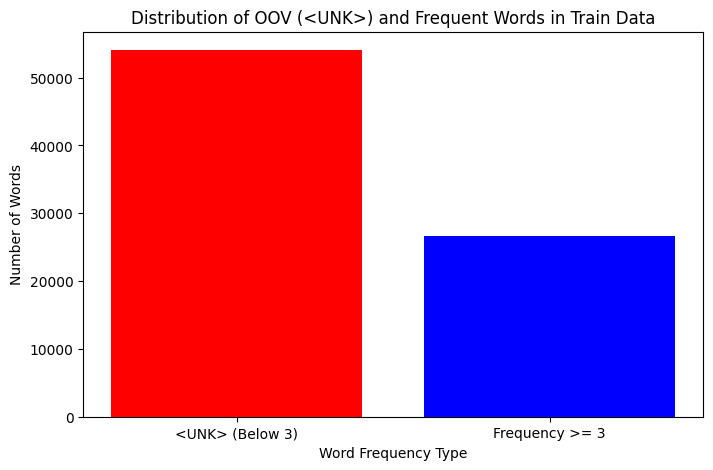

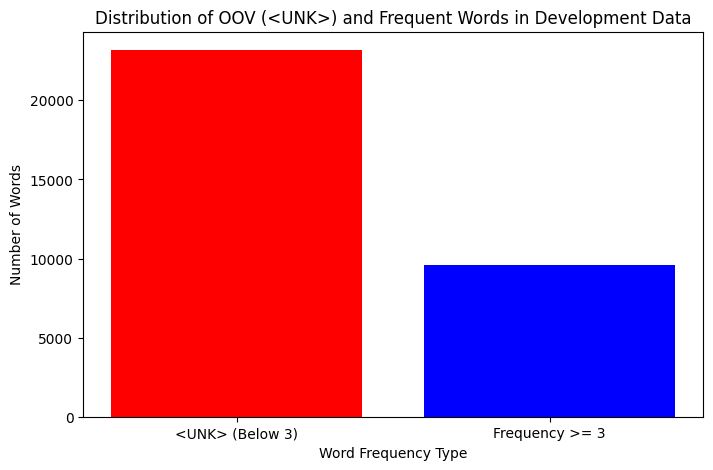

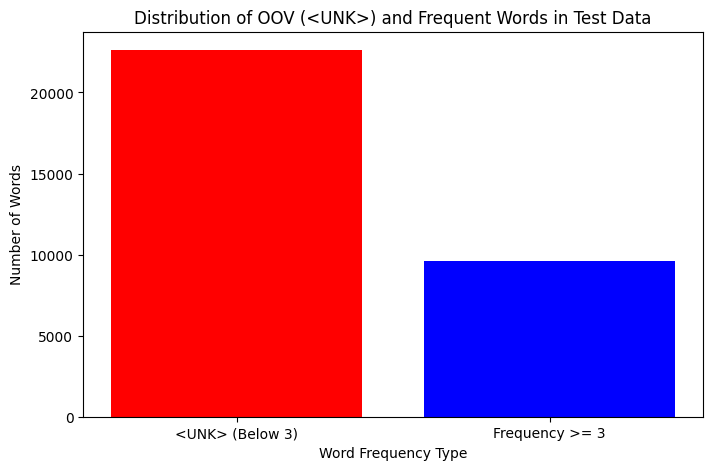

In [5]:
from collections import defaultdict
import matplotlib.pyplot as plt

# Load data function
def load_data(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        data = file.readlines()
    return [line.strip().split() for line in data]

# Process <UNK> tokens and count word frequencies
def process_unk_tokens(data, min_count=3):
    word_counts = defaultdict(int)
    for sentence in data:
        for word in sentence:
            word_counts[word] += 1

    processed_data = []
    for sentence in data:
        processed_sentence = [word if word_counts[word] >= min_count else "<UNK>" for word in sentence]
        processed_data.append(processed_sentence)
    
    return processed_data, word_counts

# Visualization function for OOV distribution
def plot_oov_distribution(word_counts, dataset_name, min_count=3):
    # Count words below and above the threshold
    frequencies = list(word_counts.values())
    below_min_count = sum(1 for freq in frequencies if freq < min_count)
    above_min_count = sum(1 for freq in frequencies if freq >= min_count)

    # Plotting the distribution
    plt.figure(figsize=(8, 5))
    plt.bar(['<UNK> (Below 3)', 'Frequency >= 3'], [below_min_count, above_min_count], color=['red', 'blue'])
    plt.title(f'Distribution of OOV (<UNK>) and Frequent Words in {dataset_name}')
    plt.xlabel('Word Frequency Type')
    plt.ylabel('Number of Words')
    plt.show()

# Load datasets
train_data = load_data('HW2/A2-Data/1b_benchmark.train.tokens')
dev_data = load_data('HW2/A2-Data/1b_benchmark.dev.tokens')
test_data = load_data('HW2/A2-Data/1b_benchmark.test.tokens')

# Process each dataset and plot OOV distribution
# Train Data
processed_train_data, train_word_counts = process_unk_tokens(train_data)
plot_oov_distribution(train_word_counts, "Train Data")

# Dev Data
processed_dev_data, dev_word_counts = process_unk_tokens(dev_data)
plot_oov_distribution(dev_word_counts, "Development Data")

# Test Data
processed_test_data, test_word_counts = process_unk_tokens(test_data)
plot_oov_distribution(test_word_counts, "Test Data")


In [6]:
# 使用全部訓練數據的困惑度計算
train_perplexity_full = calculate_interpolated_perplexity(
    unigram_model, bigram_model, trigram_model, train_data, *best_lambda_combination
)
dev_perplexity_full = calculate_interpolated_perplexity(
    unigram_model, bigram_model, trigram_model, dev_data, *best_lambda_combination
)

print("Using Full Training Data:")
print(f"Train Perplexity: {train_perplexity_full}")
print(f"Development Perplexity: {dev_perplexity_full}")

# 使用一半訓練數據的困惑度計算
half_train_data = train_data[:len(train_data) // 2]  # 取前半部分的訓練數據

# 重新訓練模型並計算困惑度
train_perplexity_half = calculate_interpolated_perplexity(
    unigram_model, bigram_model, trigram_model, half_train_data, *best_lambda_combination
)
dev_perplexity_half = calculate_interpolated_perplexity(
    unigram_model, bigram_model, trigram_model, dev_data, *best_lambda_combination
)

print("\nUsing Half of the Training Data:")
print(f"Train Perplexity: {train_perplexity_half}")
print(f"Development Perplexity: {dev_perplexity_half}")


Using Full Training Data:
Train Perplexity: 29.690699473804056
Development Perplexity: 302.6020710694266

Using Half of the Training Data:
Train Perplexity: 29.665778073961068
Development Perplexity: 302.6020710694266


In [7]:
# 更新處理 OOV 的函數，將少於 5 次的詞標記為 <UNK>
def process_unk_tokens(data, min_count=5):
    word_counts = defaultdict(int)
    for sentence in data:
        for word in sentence:
            word_counts[word] += 1

    processed_data = []
    for sentence in data:
        processed_sentence = [word if word_counts[word] >= min_count else "<UNK>" for word in sentence]
        processed_data.append(processed_sentence)
    return processed_data

# 重新處理訓練和開發數據以更新 OOV 標記
processed_train_data_oov5 = process_unk_tokens(train_data, min_count=5)
processed_dev_data_oov5 = process_unk_tokens(dev_data, min_count=5)

# 計算更新後的困惑度
train_perplexity_oov5 = calculate_interpolated_perplexity(
    unigram_model, bigram_model, trigram_model, processed_train_data_oov5, *best_lambda_combination
)
dev_perplexity_oov5 = calculate_interpolated_perplexity(
    unigram_model, bigram_model, trigram_model, processed_dev_data_oov5, *best_lambda_combination
)

print("\nUsing OOV Threshold of < 5 for <UNK> Tagging:")
print(f"Train Perplexity with <UNK> threshold 5: {train_perplexity_oov5}")
print(f"Development Perplexity with <UNK> threshold 5: {dev_perplexity_oov5}")



Using OOV Threshold of < 5 for <UNK> Tagging:
Train Perplexity with <UNK> threshold 5: 26.678470737775154
Development Perplexity with <UNK> threshold 5: 152.59260906824426
